# Introduction

Because CLIP is trained with free text, if we wish to do image classification, we need to prompt it with free text describing the class. So instead of dog, we would say a photo of a dog, or something along those lines. In this notebook, I want to test the usefulness of CLIP as an image annotator, given that we can use much richer free text labels, rather than just single word labels for the classifier. I'm going to try use photos describing scenes / images from CCTV cameras to test this in a way that is more relevent to commercial applications, rather than just usual trivial objects.

<center><img src="./presentation_images/CLIP_zero_shot.png" width = "350px"></center>

# Import necesarry libraries

In [1]:
import re
import itertools
from glob import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load CLIP

In [2]:
from clip import clip

model, preprocess_img = clip.load('ViT-B/32')

# Load & preprocess images

In [3]:
paths = glob('./data/prompt_eng_examples/*')

In [4]:
images_proc = []
images_orig = []

for path in paths:
    with Image.open(path) as f:
        image_pil = f.convert("RGB")
        images_orig.append(image_pil)
        image_proc = preprocess_img(f.convert("RGB"))
    images_proc.append(image_proc)

In [5]:
# Get images ready for inference
images_input = torch.tensor(np.stack(images_proc))

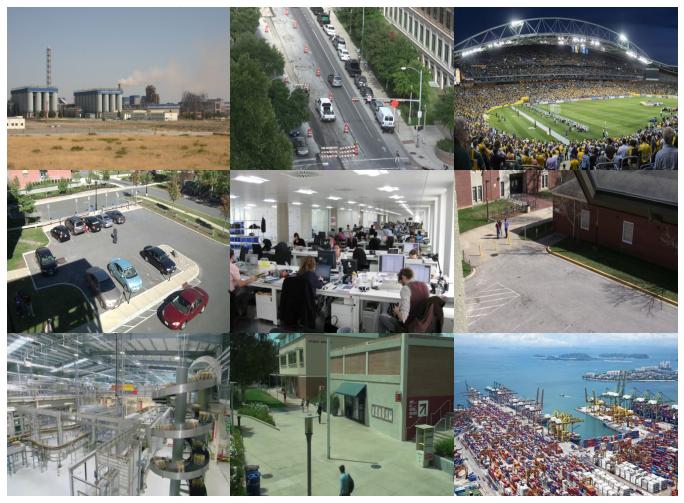

In [6]:
plt.figure(figsize = (12, 9))

for i, img in enumerate(images_orig):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, aspect = 'auto')
    plt.axis("off")

plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()

# Generate sentence combintations

In [7]:
sentence_segments = {
    'start_of_text': [
        'a picture of', 'an image of'
    ],
    'in_out': [
        'the inside of', 'the outside of', ''
    ],
    'scene_names': [
        'an office', 'a sports stadium', 'a concert stage',
        'a construction site', 'a port', 'an art gallery',
        'a factory', 'car park', 'a school', 'a university',
        'a street'
    ],
    'people': [
        'without people', 'with one person',
        'with two people', 'with three people',
        'with a group of people', 'with a crowd of people'
    ],
    'objects': [
        'and cars', 'and computers', ''
    ]
}

In [16]:
segments_combined = sentence_segments.values()
text_descriptions = [
    re.sub(' {2,}', ' ', ' '.join(i)) for i in itertools.product(*segments_combined)
]

# Tokenise sentence combinations

In [9]:
tokenized_texts = clip.tokenize(text_descriptions)

# Run inference on text and images

In [10]:
with torch.no_grad():
    logits_per_image, logits_per_text = model(images_input, tokenized_texts)
    probs = logits_per_image.softmax(dim = -1)

# Get top results

In [11]:
no_of_top = 5

top_probs, top_labels = probs.topk(no_of_top, dim = -1)

# Display results

In [12]:
def plot_clip_predictions():
    
    no_of_imgs = len(images_orig)
    
    plt.figure(figsize=(6, no_of_imgs * 3.3))

    for i, img in enumerate(images_orig):
        # Images
        plt.subplot(no_of_imgs, 2, 2 * i + 2)
        plt.imshow(img, aspect = 'auto')
        plt.axis("off")
        
        # Bar graphs with text probs
        plt.subplot(no_of_imgs, 2, 2 * i + 1)
        y = np.arange(top_probs.shape[-1])
        plt.grid()
        plt.barh(y, top_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [text_descriptions[index].capitalize() \
                       for index in top_labels[i].numpy()])
        plt.xlim([0, 1])
        plt.xlabel("Probability")
    
    plt.subplots_adjust(hspace = 0.3)
    plt.show()

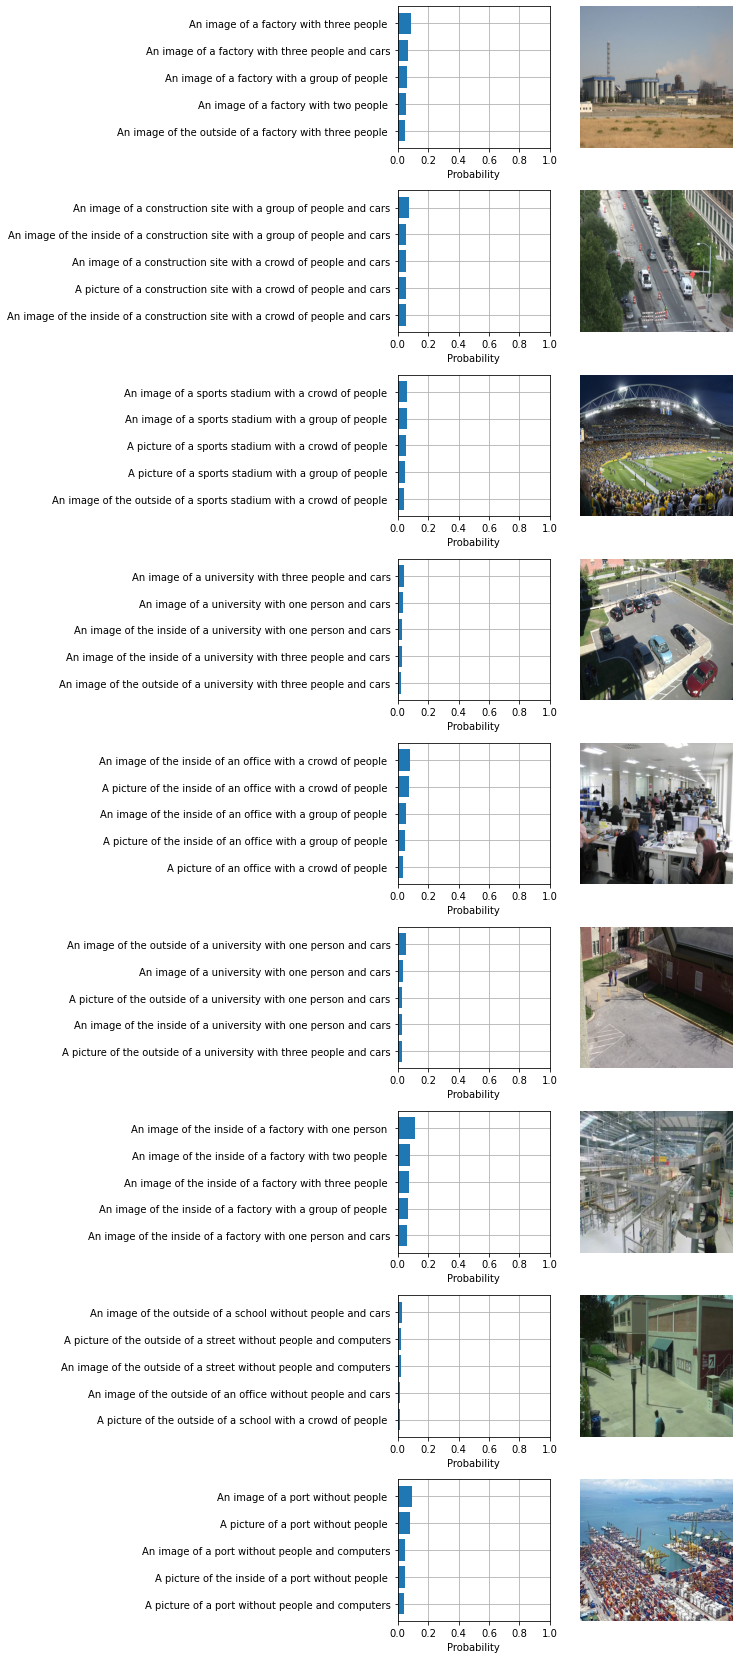

In [13]:
plot_clip_predictions()

The performance on this application is reasonable, however there are quite a few mis-classifications. Some of this is probably due to the less than optimal prompt engineering. Another avenue to explore could be making a classifier for all the scene types plus a binary classifier for attributes of interest instead of constructing free prose. These binary classifications could be used as flags for filtering (e.g. having a 'contains people' flag using something like: this image contains people, vs. this image does not contain people and picking the one with the highest probability).